# *Cloud Storage

https://drive.google.com/drive/folders/1VQgQeyEuADpT82NCIDLzbRKcTOImM1-s?usp=sharing

Files with numeric file names are data from human subjects. You should decompress these files into preproc_data directory which is in WinterCamp2021.zip .

# *Modules

In [1]:
from glob import glob
import sys
from os.path import join, dirname
# from os.path import getsize
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest

%matplotlib inline

$\textbf{Nilearn}$ enables approachable and versatile analyses of brain volumes. It provides statistical and machine-learning tools : https://nilearn.github.io/

In [2]:
# import nilearn.masking
from nilearn import plotting as nplt
from nilearn import image as niimg
import nilearn.decoding

/Users/clmn/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


$\textbf{Scikit-learn}$ is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities : https://scikit-learn.org/stable/#

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.svm import LinearSVC

In [4]:
# from datetime import date
# today = date.today().strftime("%Y%m%d")

# *create variables that point to the location of the configuration

In [5]:
root_dir = '/Volumes/T7SSD1/WinterCamp2021' # check where the data is downloaded on your disk

In [6]:
preproc_dir = root_dir + '/preproc_data'
mask_dir = root_dir + '/masks'
loc_dir = mask_dir + '/localizer'

# *MVPA
#### Multi-voxel pattern analysis (MVPA) is gaining increasing interest in the neuroimaging community because it allows to detect differences between conditions with higher sensitivity than conventional univariate analysis by focusing on the analysis and comparison of distributed patterns of activity. In such a multivariate approach, data from individual voxels within a region are jointly analyzed. Furthermore, MVPA is often presented in the context of "brain reading" applications reporting that specific mental states or representational content can be decoded from fMRI activity patterns after performing a "training" or "learning phase. In this context, MVPA tools are often referred to as classifiers or, more generally, learning machines. The latter names stress that many MVPA tools originate from a field called machine learning, a branch of artificial intelligence.

In [7]:
subj_list = ['01', '02', '05', '07', '08', '11', '12', '13', '14', '15',
             '18', '19', '20', '21', '23', '26', '27', '28', '29', '30',
             '31', '32', '33', '34', '35', '36', '37', '38', '42', '44']
stage_list = ['early_practice', 'early_unpractice', 'late_practice', 'late_unpractice']

In [8]:
def load_betas(subj, stage):
    assert subj in subj_list
    print(subj, end='\r')

    a, b = stage.split('_')
    assert ((a == 'early')|(a == 'late'))
    assert ((b == 'practice')|(b == 'unpractice'))
    g = 'GA' if a == 'early' else 'GB'
    run_list = ['r01', 'r02', 'r03'] if b == 'practice' else ['r01', 'r05', 'r06']
    
    ## load betas
    temp = {}
    for run in run_list:
        temp[g+subj, run] = niimg.load_img(join(preproc_dir,subj,'betasLSS.%s.%s.nii.gz'%(g+subj,run)))

    ## We suppose to exclude the first slice from the last dimension of this 4D-image
    for key, value in temp.items():
        temp[key] = niimg.index_img(value, np.arange(1, 97))

    ## new arrangement of previous data
    beta = {}
    beta[subj, stage] = niimg.concat_imgs([temp[g+subj, run] for run in run_list])
        
    return beta

In [9]:
subj = '01'
stage = 'late_practice'

In [10]:
beta = load_betas(subj,stage)
print(beta)
print(beta[subj,stage].shape)

{('01', 'late_practice'): <nibabel.nifti1.Nifti1Image object at 0x7ffe62227e80>}
(72, 85, 72, 288)


In [11]:
## labeling with target position
##################
#  1  2  3  4  5 #
#  6  7  8  9 10 #
# 11 12 13 14 15 #
# 16 17 18 19 20 #
# 21 22 23 24 25 #
##################
target_pos = []

with open(join(root_dir,'targetID.txt')) as file:
    for line in file:
        target_pos.append(int(line.strip()))
        
target_pos = target_pos[1:97]
# target_path = list(range(1,13))*8

In [12]:
print('target_pos:\n',target_pos)

target_pos:
 [5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1]


## *Movement-related ROIs from localizer

In [13]:
ROI_imgs = {}
## ROIs
path_list = sorted(glob(join(mask_dir,'localizer','n200_*.nii')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    ROI_imgs[roi] = niimg.load_img(path)

In [14]:
ROI_imgs

{'n200_c1-1_L_M1': <nibabel.nifti1.Nifti1Image at 0x7ffe62227790>,
 'n200_c1-2_L_S1': <nibabel.nifti1.Nifti1Image at 0x7ffe62227dc0>,
 'n200_c2_R_CerebellumIV-V': <nibabel.nifti1.Nifti1Image at 0x7ffe62227f40>,
 'n200_c3_R_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7ffe62253070>,
 'n200_c4_L_Putamen': <nibabel.nifti1.Nifti1Image at 0x7ffe62253130>,
 'n200_c5_R_SMA': <nibabel.nifti1.Nifti1Image at 0x7ffe70a10bb0>,
 'n200_c6_R_CerebellumVIIIb': <nibabel.nifti1.Nifti1Image at 0x7ffe62235610>,
 'n200_c7_L_Thalamus': <nibabel.nifti1.Nifti1Image at 0x7ffe62253700>}

### *cross validation

In [15]:
def fast_masking(img, roi):
    # img : data (NIFTI image)
    # roi : mask (NIFTI image)
    # output : (trials, voxels)-dimensional fdata array
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)
    
    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
        
    return img_data[roi_mask, :].T    # the shape is (trials, voxels) which is to cross-validate for runs

In [16]:
## LDA analysis
estimator = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

In [17]:
def cross_valid(beta, ROI_imgs, estimator):
    # output : A leave-one-run-out cross-validation (LORO-CV) result.
    #          Automatically save it as pickle file to root_dir
    ## set the parameters
    nrun = 3
    cv = GroupKFold(nrun)
    y = [j for i in range(nrun) for j in target_pos] ## answer : [5, 25, 21, 1, 25,...]
    group = [i for i in range(nrun) for j in target_pos] ## run number : [0, 0, ..., 1, 1, ..., 2, 2]
    
    ## cross-validation
    scores = {}
    for subj, stage in beta.keys():
        for name, img in ROI_imgs.items():
            print(subj, stage, name, end='\r')
            X = fast_masking(img=beta[subj, stage], roi=img)
            score = cross_validate(estimator=estimator, X=X, y=y, groups=group
                                   , cv=cv, return_estimator=True, return_train_score=True)
            scores[subj, stage, name] = score['test_score']
    return scores

In [18]:
scores = cross_valid(beta, ROI_imgs, estimator)
scores

{('01',
  'late_practice',
  'n200_c1-1_L_M1'): array([0.3125    , 0.35416667, 0.3125    ]),
 ('01',
  'late_practice',
  'n200_c1-2_L_S1'): array([0.4375    , 0.40625   , 0.29166667]),
 ('01',
  'late_practice',
  'n200_c2_R_CerebellumIV-V'): array([0.25      , 0.27083333, 0.26041667]),
 ('01',
  'late_practice',
  'n200_c3_R_Postcentral'): array([0.375     , 0.30208333, 0.28125   ]),
 ('01',
  'late_practice',
  'n200_c4_L_Putamen'): array([0.28125   , 0.28125   , 0.23958333]),
 ('01',
  'late_practice',
  'n200_c5_R_SMA'): array([0.33333333, 0.28125   , 0.22916667]),
 ('01',
  'late_practice',
  'n200_c6_R_CerebellumVIIIb'): array([0.28125   , 0.30208333, 0.3125    ]),
 ('01',
  'late_practice',
  'n200_c7_L_Thalamus'): array([0.22916667, 0.22916667, 0.28125   ])}

### group analysis (Optional)

In [19]:
betas = {}
for subj in subj_list:
    for stage in stage_list:
        beta = load_betas(subj, stage)
        betas[subj, stage] = beta[subj, stage]

In [21]:
scores = cross_valid(betas, ROI_imgs, estimator)

In [23]:
## Save it as .pickle
path = join(root_dir,'n30_dec-acc_move-rel.pkl')
with open(path,"wb") as fw:
    pickle.dump(scores, fw)

### *read the above pickle

In [7]:
path = join(root_dir,'210219_n30_dec-acc_move-rel.pkl')

In [8]:
## Load pickle
with open(path,"rb") as fr:
    scores = pickle.load(file=fr)

### *Data table

In [11]:
def make_wit_df(scroes):
    wit_df = pd.DataFrame(columns=['subj','ROI','visit','mapping','accuracy_1','accuracy_2','accuracy_3','mean_accuracy'])

    for keys, values in scores.items():
        v, m = keys[1].split('_')
        wit_df = wit_df.append(
            {'subj': keys[0]
             ,'ROI': keys[2]
             ,'visit': v
             ,'mapping': m
             ,'accuracy_1': values[0]
             ,'accuracy_2': values[1]
             ,'accuracy_3': values[2]
             ,'mean_accuracy': np.mean(values)}
            , ignore_index=True)
    return wit_df

In [12]:
wit_df = make_wit_df(scores)
wit_df

,subj,ROI,visit,mapping,accuracy_1,accuracy_2,accuracy_3,mean_accuracy
0,01,n200_c1-1_L_M1,early,practice,0.375000,0.375000,0.354167,0.368056
1,01,n200_c1-2_L_S1,early,practice,0.343750,0.385417,0.343750,0.357639
2,01,n200_c2_R_CerebellumIV-V,early,practice,0.239583,0.218750,0.322917,0.260417
3,01,n200_c3_R_Postcentral,early,practice,0.312500,0.291667,0.333333,0.312500
4,01,n200_c4_L_Putamen,early,practice,0.250000,0.322917,0.208333,0.260417
...,...,...,...,...,...,...,...,...
955,44,n200_c3_R_Postcentral,late,unpractice,0.302083,0.312500,0.302083,0.305556
956,44,n200_c4_L_Putamen,late,unpractice,0.281250,0.250000,0.250000,0.260417
957,44,n200_c5_R_SMA,late,unpractice,0.239583,0.312500,0.302083,0.284722
958,44,n200_c6_R_CerebellumVIIIb,late,unpractice,0.322917,0.291667,0.229167,0.281250


### t-test (Optional)

In [12]:
ROI_list = wit_df.ROI.unique()

In [13]:
def wit_df_t_test(wit_df, cond_A, cond_B):
    ## cond_A vs. cond_B :
    ### early_practice vs. late_practice
    ### early_unpractice vs. late_unpractice
    ### early_practice vs. early_unpractice
    ### late_practice vs. late_unpractice
    a1, a2 = cond_A.split('_')
    assert a1 in ['early', 'late']
    assert a2 in ['practice', 'unpractice']
    b1, b2 = cond_B.split('_')
    assert b1 in ['early', 'late']
    assert b2 in ['practice', 'unpractice']
    
    if a1 == b1:
        steady = a1
        compare = [a2,b2]
    elif a2 == b2:
        steady = a2
        compare = [a1,b1]        

    ttest = {}
    pvals = {}
    
    ROI_list = wit_df.ROI.unique()
    for roi in ROI_list:
        A = wit_df[(wit_df.ROI==roi)&(wit_df.stage==cond_A)]['mean_accuracy']
        B = wit_df[(wit_df.ROI==roi)&(wit_df.stage==cond_B)]['mean_accuracy']
        ttest[roi,steady,compare[0]+'_vs_'+compare[1]] = scipy.stats.ttest_rel(A, B)
        pvals[roi,steady,compare[0]+'_vs_'+compare[1]] = statsmodels.stats.multitest.fdrcorrection(ttest[roi,steady,compare[0]+'_vs_'+compare[1]].pvalue)
        
    return pvals

In [14]:
wit_df_t_test(wit_df=wit_df, cond_A='early_practice', cond_B='late_practice')

TypeError: wit_df_t_test() got an unexpected keyword argument 'cond_A'

### *Drawing figures

In [15]:
## background image
img_bg = join(root_dir,'mni152_2009bet.nii.gz')

In [24]:
sns.set(style="ticks", context='talk')
palette = ['#C5C7D2', '#00A8AA', '#C5C7D2', '#00A8AA']

def draw_lineplot(roi_name, title, ax=None):
    
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    ax = sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, ax=ax,
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    ax.set_xlim((-0.4, 1.4))
    ax.set_ylim(0.225, 0.55)
    ax.set_yticks(np.arange(.25,.70,.15))
    ax.set_ylabel('Decoding Accuracy')
    ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.25)
#     ax.get_legend().remove()
    ax.legend(loc='best', frameon=True)
    ax.set_title(title)
    
    return ax

In [16]:
sns.set(style="ticks", context='talk')
palette = ['#C5C7D2', '#00A8AA', '#C5C7D2', '#00A8AA']

def draw_lineplot(wit_df, ROI_name, title, ax=None):
    temp = wit_df[wit_df.ROI==ROI_name]
    ax = sns.pointplot(x='visit', y='mean_accuracy', hue='mapping', data=temp, ax=ax
                       , palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    ax.set_xlim((-0.4, 1.4))
    ax.set_ylim(0.225, 0.55)
    ax.set_yticks(np.arange(.25,.70,.15))
    ax.set_ylabel('Decoding Accuracy')
    ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.25)
#     ax.get_legend().remove()
    ax.legend(loc='best', frameon=True)
    ax.set_title(title)
    
    return ax

NameError: name 'roi_names' is not defined

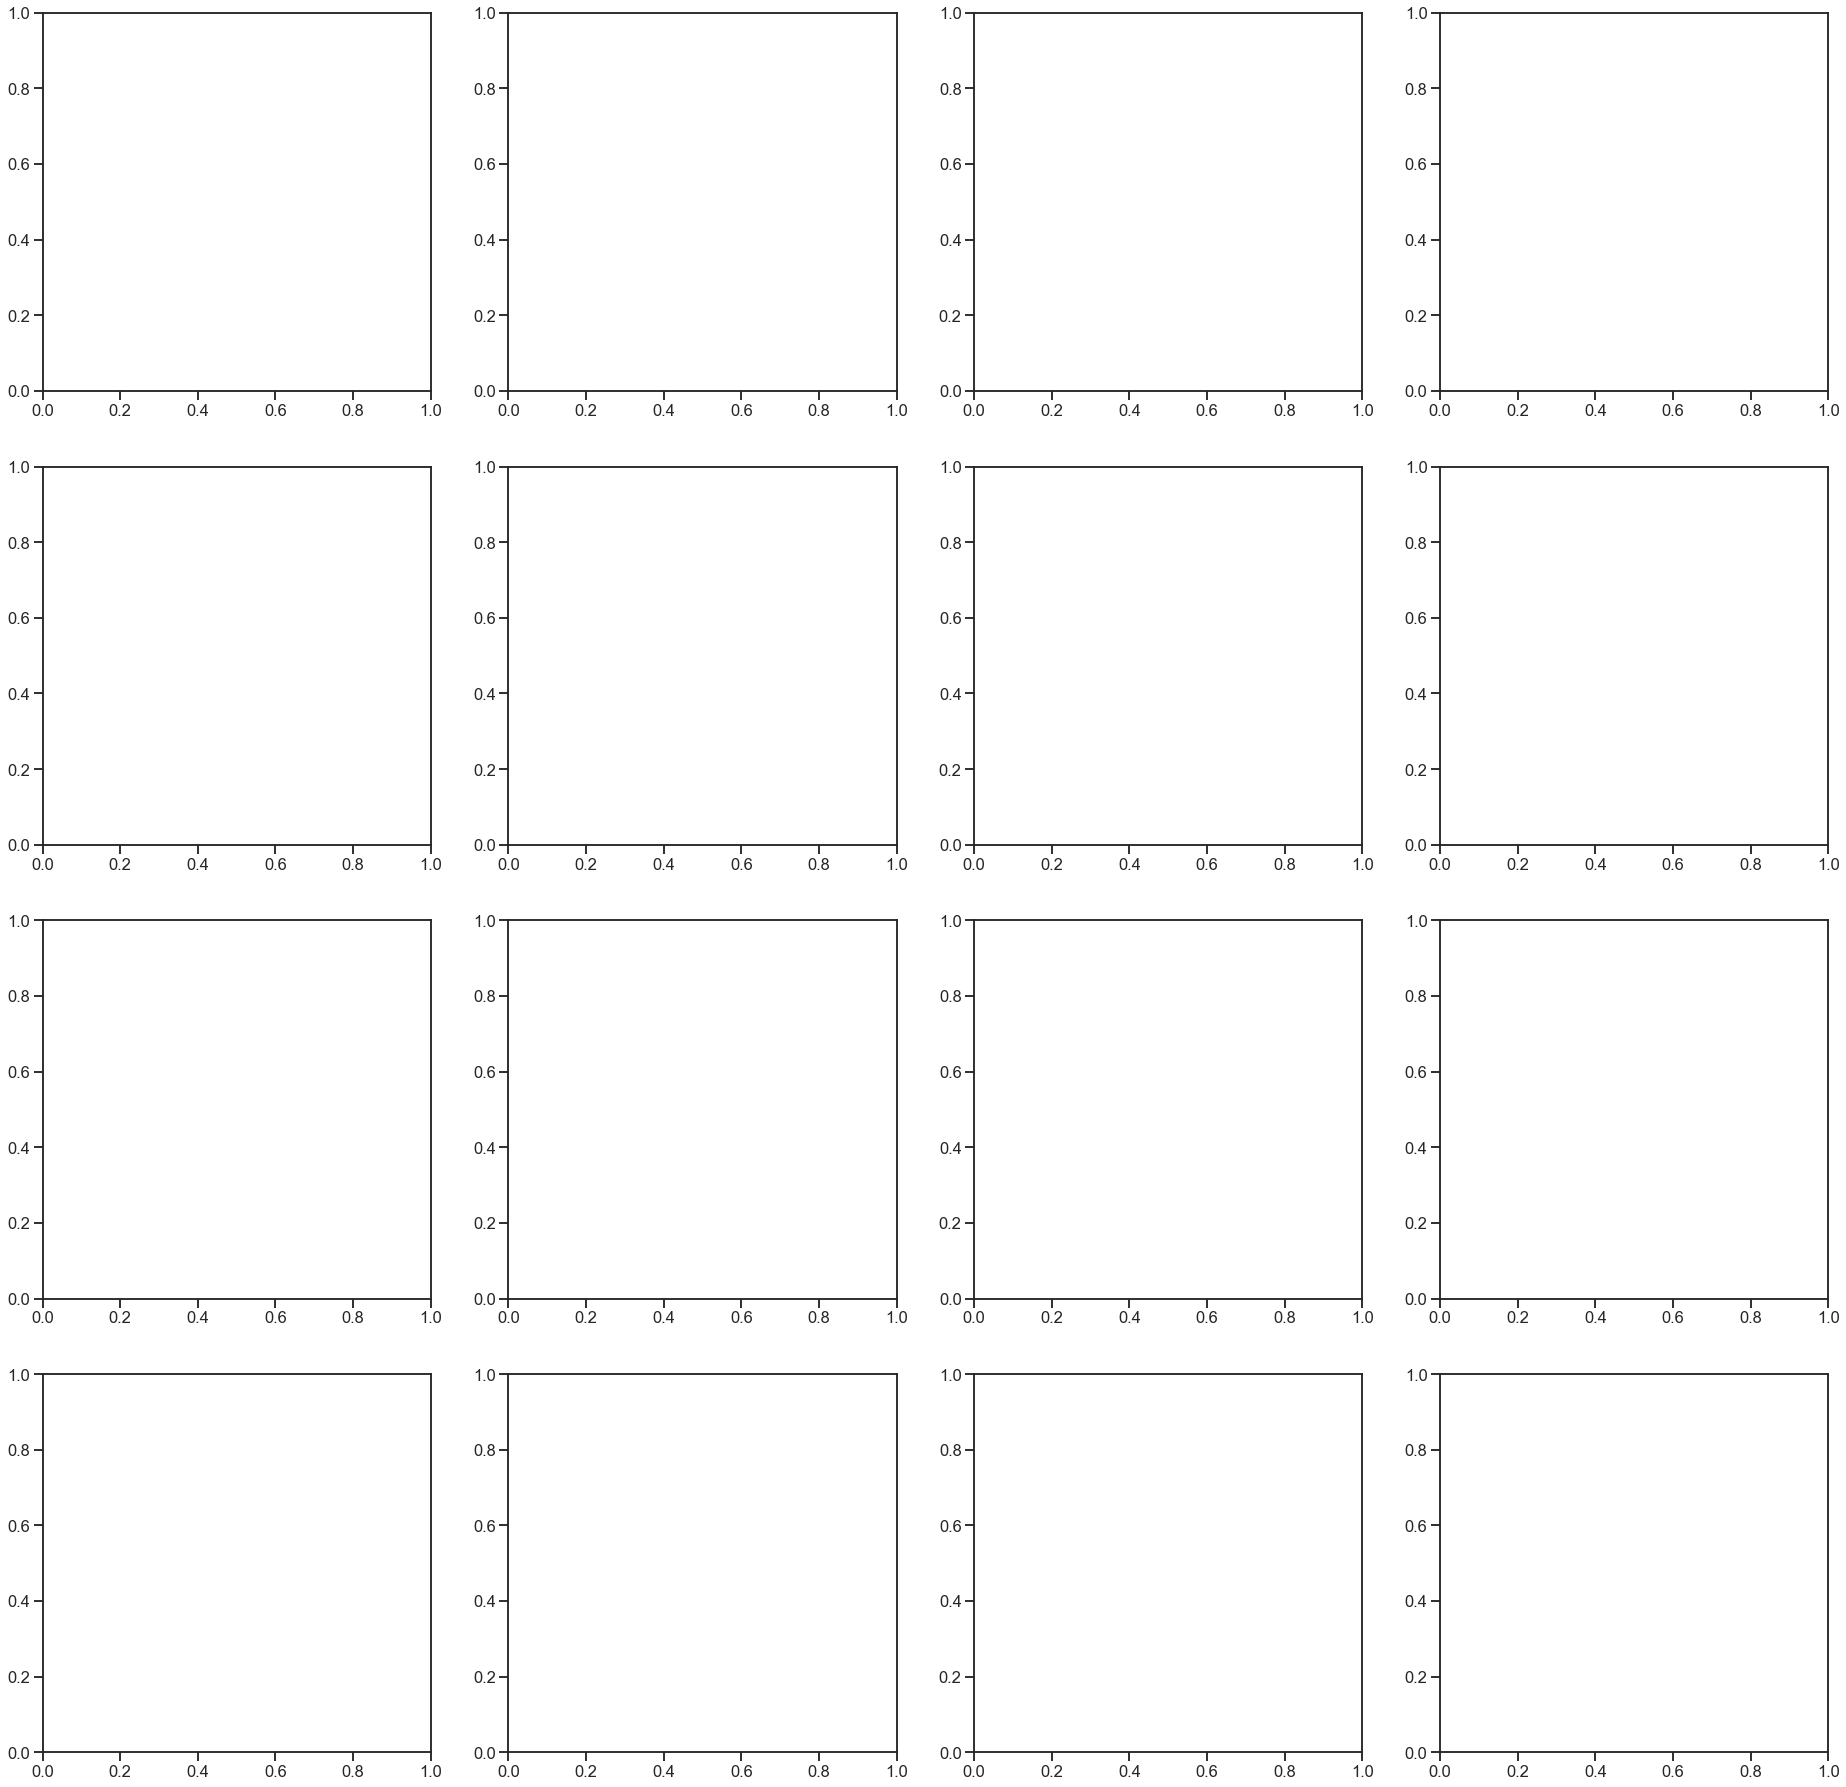

In [17]:
title_list = ['Left Precentral'
              , 'Left Postcentral'
              , 'Right Cerebellum IV-V'
              , 'Right Postcentral'
              , 'Left Putamen'
              , 'Right SMA'
              , 'Right Cerebellum VIIIb'
              , 'Left Thalamus']
ncol = 4
nrow = 4
magn = 8
_, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))
axes = np.concatenate(axes)
for idx, title in enumerate(title_list):
    ax = draw_lineplot(wit_df, ROI_name=, title, ax=axes[idx+(idx//ncol)*ncol])
    nplt.plot_roi(roi_img=roi_imgs[roi_name], bg_img=img_bg, title=name
                  , draw_cross=False, black_bg=False
                  , display_mode='ortho', axes=axes[idx+(idx//ncol)*ncol+ncol])

## SearchLight

In [15]:
def run_searchlight(full_mask, X, y, group, cv, estimator, radius, chance_level):

    searchlight = nilearn.decoding.SearchLight(
        full_mask
        , radius=radius
        , estimator=estimator
        , n_jobs=4
        , verbose=False
        , cv=cv
        , scoring='balanced_accuracy'
    )

    searchlight.fit(X, y, group)
    score = searchlight.scores_ - chance_level

    return nilearn.image.new_img_like(full_mask, score)

In [21]:
def searchlight(estimator, radius, chance_level, output_dir, prefix):
    
    os.makedirs(output_dir, exist_ok=True)
    
    nrun=3
    cv = GroupKFold(nrun)
    y = [j for i in range(nrun) for j in target_pos] # answer
    group = [i for i in range(nrun) for j in target_pos] # run number
    
    for ii in id_list:
        for nn in nn_list:
            subj = ii + nn
            print(subj, end='\r')
            path = join(mask_dir,'full','full_mask.GA%s.nii.gz'%nn)
            full_mask = nilearn.image.load_img(path)
            X = nilearn.image.concat_imgs(np.array([data[subj,rr] for rr in run_list[:3]]))
            searchlight_img = run_searchlight(full_mask, X, y, group, cv, estimator, radius, chance_level)
            searchlight_img.to_filename(join(output_dir,'%s.%s.r%d.nii.gz'%(prefix, subj, radius)))

In [22]:
# estimator = LinearSVC(max_iter=1000)
estimator = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
radius=6
chance_level=0.25
output_dir = join(root_dir,'searchlight')
searchlight(estimator, radius, chance_level, output_dir, prefix='lda')

KeyboardInterrupt: 

### Visualization